In [6]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth
auth.authenticate_user()

%cd /content/drive/MyDrive/pixelNeRF

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1g2dktPblP5elov4ll96wfHuJKzZndl5X/pixelNeRF


In [ ]:
# Usage: bash scripts/fetch2local.sh -from <bucket/prefix> [-to <extract_path>]
#       -to : /content/pixNeRF_shapeNet_v2_data [DEFAULT]
!bash fetch2local.sh -from nerf-data-ssu/shapeNetV2_cars

Pixel-NeRF GCS Fetcher (Stable v2)
------------------------------------------
BUCKET   : nerf-data-ssu
PREFIX   : shapeNetV2_cars
SOURCE   : gs://nerf-data-ssu/shapeNetV2_cars
ZIP SAVE : /content/load_data
EXTRACT  : /content/pixNeRF_shapeNet_v2_data
Reinstalling crcmod with C-extension...
Skipping Colab authentication (not detected).
Scanning for ZIP files in gs://nerf-data-ssu/shapeNetV2_cars...
 [ Found 5 ZIP files ]
gs://nerf-data-ssu/shapeNetV2_cars/cars_test.zip
gs://nerf-data-ssu/shapeNetV2_cars/cars_train.zip
gs://nerf-data-ssu/shapeNetV2_cars/cars_train_test.zip
gs://nerf-data-ssu/shapeNetV2_cars/cars_train_val.zip
gs://nerf-data-ssu/shapeNetV2_cars/cars_val.zip
------------------------------------------
 [ Download ] ZIP files to /content/load_data...
Copying gs://nerf-data-ssu/shapeNetV2_cars/cars_test.zip...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default

- 추론용 데이터(예시) 샘플링

🔒 [Mode] Using Specified Object ID
🧹 Cleared: data/input
🎯 Using Specified Object ID: afa0436d9cb1b19ec8c241cb24f7e0ac
🔍 Filtering images (Max Elevation: 50.0°)...
✅ Filtered: Kept 139 / 251 images. (Skipped 112 high-angle views)
✅ Data ready at: data/input/example1


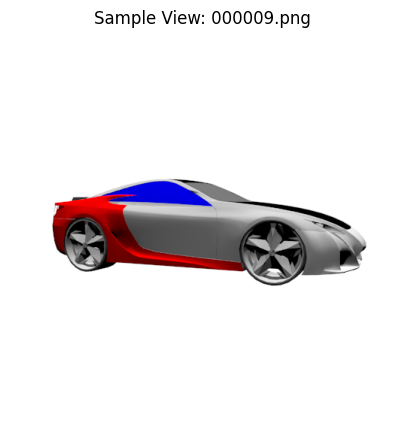

📸 Image Preview displayed.

🚀 Next Step Input Path: data/input/example1
🆔 Selected Object ID Variable: afa0436d9cb1b19ec8c241cb24f7e0ac


In [ ]:
import os
import shutil
import random
import glob
import numpy as np  # 수학 계산을 위해 추가
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ================= Configuration =================
SOURCE_DATA_ROOT = "/content/pixNeRF_shapeNet_v2_data/cars_test"
TARGET_ROOT = "data/input"      # 폴더 초기화
OUTPUT_DIR_NAME = "example1"      # 초기화 후 생성할 폴더 이름
NUM_VIEWS = 6              # 가져올 이미지 개수
MAX_ELEVATION = 50.0       # 이 각도보다 높은(머리 위) 뷰는 제외
# =================================================

def clean_and_setup_dirs(root_path, new_dir_name):
    if os.path.exists(root_path):
        try:
            shutil.rmtree(root_path)
            print(f"🧹 Cleared: {root_path}")
        except Exception as e:
            print(f"❌ Error: {e}")
            return None
    os.makedirs(root_path, exist_ok=True)
    final_target_path = os.path.join(root_path, new_dir_name)
    os.makedirs(final_target_path, exist_ok=True)
    return final_target_path

def get_elevation_from_pose(pose_path):
    """포즈 파일에서 고도(Elevation) 각도를 계산합니다."""
    try:
        with open(pose_path, 'r') as f:
            values = [float(x) for x in f.read().split()]

        # 4x4 행렬로 변환
        pose = np.array(values).reshape(4, 4)

        # 카메라 위치 (Translation Vector)
        loc = pose[:3, 3] # x, y, z

        # 반지름(거리) 계산
        radius = np.linalg.norm(loc)

        # 고도 계산 (Z축이 Up이라고 가정하는 ShapeNet 관례 따름)
        # sin(ele) = z / radius
        if radius < 1e-6:
            return 0.0

        elevation = np.degrees(np.arcsin(loc[2] / radius))
        return elevation

    except Exception as e:
        print(f"⚠️ Pose parsing error {pose_path}: {e}")
        return 999.0 # 에러 시 필터링되도록 큰 값 반환

def prepare_data(specific_obj_id=None):
    dst_obj_path = clean_and_setup_dirs(TARGET_ROOT, OUTPUT_DIR_NAME)
    if dst_obj_path is None: return None, None

    # 소스 데이터 선택
    if not os.path.exists(SOURCE_DATA_ROOT):
        print(f"❌ Source path not found.")
        return None, None

    # 특정 ID가 주어졌는지 확인하고 처리
    if specific_obj_id:
        obj_id = specific_obj_id
        src_obj_path = os.path.join(SOURCE_DATA_ROOT, obj_id)
        if not os.path.exists(src_obj_path):
            print(f"❌ Specified Object ID '{obj_id}' not found in source directory.")
            return None, None
        print(f"🎯 Using Specified Object ID: {obj_id}")
    else:
        objects = [d for d in os.listdir(SOURCE_DATA_ROOT) if os.path.isdir(os.path.join(SOURCE_DATA_ROOT, d))]
        if not objects:
            print("❌ No objects found in source directory.")
            return None, None
        obj_id = random.choice(objects)
        src_obj_path = os.path.join(SOURCE_DATA_ROOT, obj_id)
        print(f"🔄 Selected Random Object ID: {obj_id}")


    # 이미지 파일 리스트 확보
    images = glob.glob(os.path.join(src_obj_path, 'rgb', '*.[pj][np]g'))
    all_indices = sorted([int(os.path.splitext(os.path.basename(f))[0]) for f in images if f[-7:-4].isdigit()])

    if not all_indices:
         print("❌ No valid images found.")
         return None, None

    # -----------------------------------------------------------
    # 🔍 [추가됨] 고도 필터링 로직 (Elevation Filtering)
    # -----------------------------------------------------------
    valid_indices = []
    skipped_count = 0

    print(f"🔍 Filtering images (Max Elevation: {MAX_ELEVATION}°)...")

    for idx in all_indices:
        fname = f"{idx:06d}"
        pose_file = os.path.join(src_obj_path, 'pose', f"{fname}.txt")

        if os.path.exists(pose_file):
            elev = get_elevation_from_pose(pose_file)

            # 절대값 75도 이하인 것만 포함 (위쪽 75도 이상 제외)
            if abs(elev) <= MAX_ELEVATION:
                valid_indices.append(idx)
            else:
                skipped_count += 1
        else:
            # 포즈 파일이 없으면 안전하게 제외 (혹은 포함)
            pass

    print(f"✅ Filtered: Kept {len(valid_indices)} / {len(all_indices)} images. (Skipped {skipped_count} high-angle views)")

    if len(valid_indices) < NUM_VIEWS:
        print(f"⚠️ Warning: 남은 이미지가 요청한 개수({NUM_VIEWS})보다 적습니다. ({len(valid_indices)}장)")
        selected_indices = valid_indices # 있는 거라도 다 씀
    else:
        selected_indices = sorted(random.sample(valid_indices, NUM_VIEWS))
    # -----------------------------------------------------------

    # 필요한 폴더 생성
    for subdir in ['rgb', 'pose', 'intrinsics']:
        os.makedirs(os.path.join(dst_obj_path, subdir), exist_ok=True)

    global_intrinsic = os.path.join(src_obj_path, 'intrinsics.txt')
    if os.path.exists(global_intrinsic): shutil.copy(global_intrinsic, dst_obj_path)

    # 선택된 파일 복사
    for idx in selected_indices:
        fname = f"{idx:06d}"
        src_img = os.path.join(src_obj_path, 'rgb', f"{fname}.png")
        if not os.path.exists(src_img): src_img = src_img.replace('.png', '.jpg')

        if os.path.exists(src_img):
            shutil.copy(src_img, os.path.join(dst_obj_path, 'rgb', os.path.basename(src_img)))
            pose_file = os.path.join(src_obj_path, 'pose', f"{fname}.txt")
            int_file = os.path.join(src_obj_path, 'intrinsics', f"{fname}.txt")
            if os.path.exists(pose_file): shutil.copy(pose_file, os.path.join(dst_obj_path, 'pose'))
            if os.path.exists(int_file): shutil.copy(int_file, os.path.join(dst_obj_path, 'intrinsics'))

    print(f"✅ Data ready at: {dst_obj_path}")

    # =================================================================
    # 📸 Preview
    # =================================================================
    preview_images = glob.glob(os.path.join(dst_obj_path, 'rgb', '*'))
    if preview_images:
        sample_img_path = preview_images[0]
        try:
            img = mpimg.imread(sample_img_path)
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.title(f"Sample View: {os.path.basename(sample_img_path)}")
            plt.axis('off')
            plt.show()
            print(f"📸 Image Preview displayed.")
        except Exception as e:
            print(f"⚠️ Could not display image: {e}")
    else:
        print("⚠️ No images found to display.")

    # ✅ 경로와 함께 obj_id도 반환
    return dst_obj_path, obj_id

# =================================================================
# 🚀 실행 및 변수 저장
# =================================================================
#  특정 ID 지정
target_id = "afa0436d9cb1b19ec8c241cb24f7e0ac"
# ------------------------------------------------------------------

if target_id:
    # ID가 지정된 경우
    print(f"🔒 [Mode] Using Specified Object ID")
    generated_path, selected_obj_id = prepare_data(specific_obj_id=target_id)
else:
    # ID가 없는 경우 (None 또는 빈 문자열) -> 랜덤 선택
    print(f"🎲 [Mode] Random Selection")
    generated_path, selected_obj_id = prepare_data()

if generated_path:
    INPUT_ROOT = generated_path
    print(f"\n🚀 Next Step Input Path: {INPUT_ROOT}")
    print(f"🆔 Selected Object ID Variable: {selected_obj_id}")

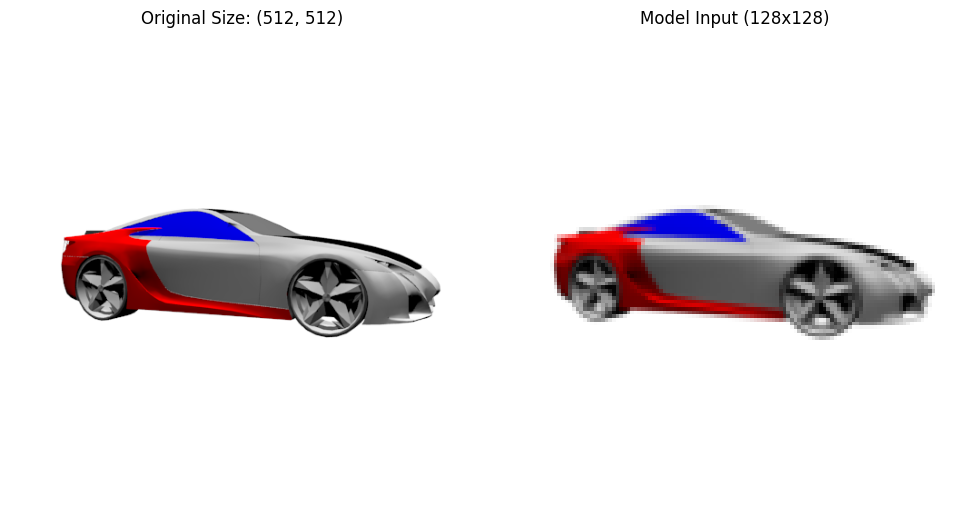

✅ Loaded: 000009.png


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

# ================= Configuration =================
INPUT_DIR = "data/input/example1/rgb"  # 이미지가 저장된 경로
TARGET_SIZE = (128, 128)               # 모델에 들어가는 크기
# =================================================

def show_resized_example():
    # 1. 이미지 파일 찾기
    img_paths = sorted(glob.glob(os.path.join(INPUT_DIR, "*.[pj][np]g")))

    if not img_paths:
        print(f"❌ '{INPUT_DIR}' 경로에 이미지가 없습니다.")
        return

    # 2. 첫 번째 이미지 가져오기 (원하는 인덱스로 변경 가능)
    # 예: img_paths[0], img_paths[3] 등
    sample_path = img_paths[0]

    try:
        # 원본 로드
        original_img = Image.open(sample_path).convert("RGB")

        # 3. 128x128로 리사이즈 (NeRF 모델이 보는 세상)
        resized_img = original_img.resize(TARGET_SIZE, Image.BILINEAR)

        # 4. 비교 출력
        plt.figure(figsize=(10, 5))

        # 원본
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title(f"Original Size: {original_img.size}")
        plt.axis("off")

        # 128x128 (모델 시점)
        plt.subplot(1, 2, 2)
        plt.imshow(resized_img)
        plt.title(f"Model Input ({TARGET_SIZE[0]}x{TARGET_SIZE[1]})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        print(f"✅ Loaded: {os.path.basename(sample_path)}")

    except Exception as e:
        print(f"⚠️ Error: {e}")

# 실행
show_resized_example()

# infer


1. 360도 비디오 생성
```
python inference.py --input_folder ./data/shapenet/cars_test/example_car \
                    --mode video \
                    --output_dir ./outputs_video
```

2. N개 뷰 생성
```
python inference.py --input_folder ./data/shapenet/cars_test/example_car \
                    --mode views \
                    --num_frames 50 \
                    --output_dir ./outputs_dataset
```


- N 개 뷰 생성


In [ ]:
TARGET_ROOT = "/data/input"      # 폴더 초기화
OUTPUT_DIR_NAME = "example1"      # 초기화 후 생성할 폴더 이름
INPUT_ROOT = TARGET_ROOT + "/" + OUTPUT_DIR_NAME
!python -u inference.py --input_folder {INPUT_ROOT} \
                        --mode views \
                        --num_frames 10 \
                        --output_dir ./outputs \
                        --size 128 \
                        # TTO 적용

- 360도 뷰 생성

In [ ]:
TARGET_ROOT = "data/input/"      # 폴더 초기화
OUTPUT_DIR_NAME = "example1"
INPUT_ROOT =  TARGET_ROOT + OUTPUT_DIR_NAME
!python -u inference.py --input_folder {INPUT_ROOT} \
                        --mode video \
                        --output_dir ./outputs \
                        --size 128 \
                        --num_frames 120 \
                        --obj_id {selected_obj_id}

Initializing Model on cuda...
✅ Weights loaded successfully
📂 Loading data from: data/input/example1 (Size: (128, 128))

[TTO] Starting Optimization for 500 steps...
   Optimizing | Loss: 0.0018 | PSNR: 27.56 dB: 100% 500/500 [06:59<00:00,  1.19it/s]
[TTO] Finished!

[Rendering] Generating Clean 360 Orbit Video...
Rendering Loop: 100%|█████████████████████████████████████████████| 120/120 [21:35<00:00, 10.80s/it]
✨ Orbit Video saved to: ./outputs/orbit_afa0436d9cb1b19ec8c241cb24f7e0ac_128_6.mp4 (FPS: 30)


-  GT

📂 Processing Object ID: afa0436d9cb1b19ec8c241cb24f7e0ac
📊 Stats: Median Ele 45.0°, Median Rad 1.300
✅ Selected View Index: 93
   - Azimuth: 359.6° (Target: 0°)
   - Elevation: 33.5° (Median: 45.0°)

✨ Image Saved: outputs/GT_start_frame_afa0436d9cb1b19ec8c241cb24f7e0ac_128.png


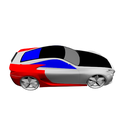

In [ ]:
import os
import glob
import numpy as np
import torch
import imageio
from PIL import Image
import math

# ==========================================
# 1. 설정 (Configuration)
# ==========================================
OBJ_ID = "afa0436d9cb1b19ec8c241cb24f7e0ac"
SOURCE_DATA_ROOT = "/content/pixNeRF_shapeNet_v2_data/cars_test"
OUTPUT_DIR = "outputs"
RENDER_SIZE = 128

# 검색 범위: 0도 근처 ±10도 내의 사진을 찾음
SEARCH_WINDOW = 10.0

# ==========================================
# 2. 유틸리티 함수
# ==========================================
def parse_pose_file(path):
    with open(path, 'r') as f:
        values = [float(x) for x in f.read().split()]
    return torch.tensor(values, dtype=torch.float32).reshape(4, 4)

def get_raw_metrics(pose_raw):
    """inference.py와 동일한 기준(Raw Space)으로 각도 계산"""
    loc = pose_raw[:3, 3] # x, y, z
    radius = np.linalg.norm(loc)

    if radius == 0: elevation = 0
    else: elevation = np.degrees(np.arcsin(loc[2] / radius))

    azimuth = np.degrees(np.arctan2(loc[1], loc[0]))
    if azimuth < 0: azimuth += 360

    return radius, azimuth, elevation

def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

# ==========================================
# 3. 데이터 로드 및 분석
# ==========================================
obj_dir = os.path.join(SOURCE_DATA_ROOT, OBJ_ID)
rgb_dir = os.path.join(obj_dir, 'rgb')
pose_dir = os.path.join(obj_dir, 'pose')

print(f"📂 Processing Object ID: {OBJ_ID}")

img_paths = sorted(glob.glob(os.path.join(rgb_dir, "*.png")) + glob.glob(os.path.join(rgb_dir, "*.jpg")))
pose_paths = sorted(glob.glob(os.path.join(pose_dir, "*.txt")))

if not img_paths: raise FileNotFoundError("❌ 데이터가 없습니다.")

# 전체 후보군 분석
all_candidates = []
for i in range(min(len(img_paths), len(pose_paths))):
    # Raw Pose 사용 (시작점 동기화 필수)
    pose_raw = parse_pose_file(pose_paths[i]).numpy()
    radius, azimuth, elevation = get_raw_metrics(pose_raw)

    all_candidates.append({
        'index': i,
        'radius': radius,
        'azimuth': azimuth,
        'elevation': elevation,
        'path': img_paths[i]
    })

# 기준점(Median) 계산 -> 줌(Zoom)과 높이 안정화를 위함
median_radius = np.median([c['radius'] for c in all_candidates])
median_elevation = np.median([c['elevation'] for c in all_candidates])

print(f"📊 Stats: Median Ele {median_elevation:.1f}°, Median Rad {median_radius:.3f}")

# ==========================================
# 4. 0도(Start) 이미지 찾기 및 보정
# ==========================================
TARGET_ANGLE = 0.0  # inference.py의 시작 각도

# 1. 0도 근처 후보 찾기
candidates = []
for item in all_candidates:
    diff = abs(item['azimuth'] - TARGET_ANGLE)
    diff = min(diff, 360 - diff) # 360도 경계 처리

    if diff <= SEARCH_WINDOW:
        candidates.append(item)

# 후보 없으면 가장 가까운 것 강제 선택
if not candidates:
    best_item = min(all_candidates, key=lambda x: min(abs(x['azimuth'] - TARGET_ANGLE), 360 - abs(x['azimuth'] - TARGET_ANGLE)))
    candidates = [best_item]

# 2. 최적의 1장 선발 (높이가 평균에 가장 가까운 것)
best_candidate = None
min_score = 9999.0

for cand in candidates:
    # 점수 = (높이 오차 x 10) + 각도 오차
    # 높이가 평균값(Median)과 비슷한 것을 최우선으로 뽑음
    ele_error = abs(cand['elevation'] - median_elevation)
    azi_error = min(abs(cand['azimuth'] - TARGET_ANGLE), 360 - abs(cand['azimuth'] - TARGET_ANGLE))

    score = (ele_error * 10.0) + azi_error

    if score < min_score:
        min_score = score
        best_candidate = cand

print(f"✅ Selected View Index: {best_candidate['index']}")
print(f"   - Azimuth: {best_candidate['azimuth']:.1f}° (Target: 0°)")
print(f"   - Elevation: {best_candidate['elevation']:.1f}° (Median: {median_elevation:.1f}°)")

# 3. 이미지 로드 및 줌 보정 (Stabilization)
img = Image.open(best_candidate['path']).convert("RGB")

# 거리(Radius)에 따른 크기 보정
scale_factor = best_candidate['radius'] / median_radius
target_scale_size = int(RENDER_SIZE * scale_factor)
if target_scale_size < RENDER_SIZE: target_scale_size = RENDER_SIZE

img_resized = img.resize((target_scale_size, target_scale_size), Image.LANCZOS)
final_img = crop_center(img_resized, RENDER_SIZE, RENDER_SIZE)

# ==========================================
# 5. 저장
# ==========================================
os.makedirs(OUTPUT_DIR, exist_ok=True)
save_filename = f"GT_start_frame_{OBJ_ID}_{RENDER_SIZE}.png"
save_path = os.path.join(OUTPUT_DIR, save_filename)

imageio.imwrite(save_path, np.array(final_img))

print(f"\n✨ Image Saved: {save_path}")

# Colab 미리보기
display(final_img)